In [187]:
import numpy as np
import math

In [188]:
pop_size = 100
n_genes = 50
n_generations = 200

In [204]:
mutation_rate = 1 / n_genes

In [206]:
def get_weights(n):
    weights = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                weights[i][j] = np.random.choice([-1, 1])

    return weights

In [207]:
population = np.random.choice([1, -1], size=(pop_size, n_genes))
w = get_weights(n_genes)

In [208]:
def get_fitness(g, w, n_genes):
    return sum([sum([w[i][j] * g[i] * g[j] for j in range(n_genes)]) for i in range(n_genes)])

In [214]:
def ga_solution(population, elitism, crossover, n_generations, mutation_rate):
    fitness_over_time = np.zeros(n_generations)
    fitness = np.zeros(pop_size)
    for i in range(pop_size):
        fitness[i] = get_fitness(population[i], w, n_genes)

    current_population = population

    for i in range(n_generations):
        # create new population
        new_pop = np.zeros((pop_size, n_genes))
        new_fitness = np.zeros(pop_size)

        # sort population by fitness
        ranked_fitness = np.argsort(fitness)

        # roulette wheel
        wheel = np.cumsum(range(pop_size))
        max_wheel = wheel[-1]

        # elitism (add the best individual to the new population)
        if elitism:
            max_ind = ranked_fitness[0]
            new_pop[0, :] = current_population[max_ind, :]
            new_fitness[0] = fitness[max_ind]

        start_point = 1 if elitism else 0
        for j in range(start_point, pop_size):
            if crossover:
                # Pick the first individual
                pick_1 = np.random.rand() * max_wheel
                ind_1 = 1
                while pick_1 > wheel[ind_1]:
                    ind_1 += 1

                # Pick the first individual
                pick_2 = np.random.rand() * max_wheel
                ind_2 = 1
                while pick_2 > wheel[ind_2]:
                    ind_2 += 1

                ind_1 = ranked_fitness[ind_1]
                ind_2 = ranked_fitness[ind_2]

                # Perform crossover
                cross_over_point = np.random.choice(range(n_genes))
                parent_1_genes = current_population[ind_1, :][0:cross_over_point]
                parent_2_genes = current_population[ind_2, :][cross_over_point:]
                daughter = np.hstack([parent_1_genes, parent_2_genes])
            else:
                pick_1 = np.random.rand() * max_wheel
                ind_1 = 1
                while pick_1 > wheel[ind_1]:
                    ind_1 += 1
                daughter = current_population[ind_1]

            for k in range(n_genes):
                if np.random.rand() < mutation_rate:
                    daughter[k] = -1 * daughter[k]

            new_pop[j, :] = daughter
            new_fitness[j] = get_fitness(daughter, w, n_genes)

        fitness_over_time[i] = max(new_fitness)
        current_population = new_pop
        fitness = new_fitness

    return fitness_over_time

In [215]:
fitness_over_time_crossover = ga_solution(population, True, True, n_generations, mutation_rate)

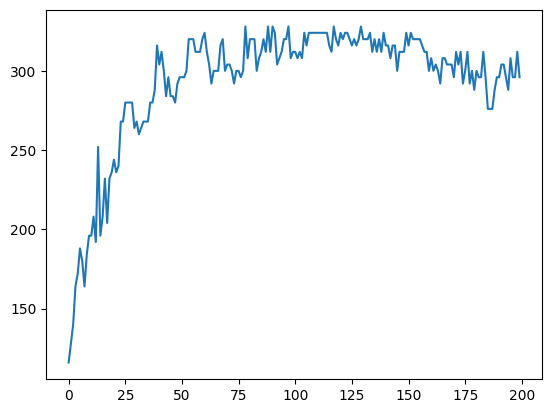

In [216]:
import matplotlib.pyplot as plt

plt.plot(fitness_over_time_crossover)

In [217]:
fitness_over_time_no_crossover = ga_solution(population, True, False, 500, mutation_rate)

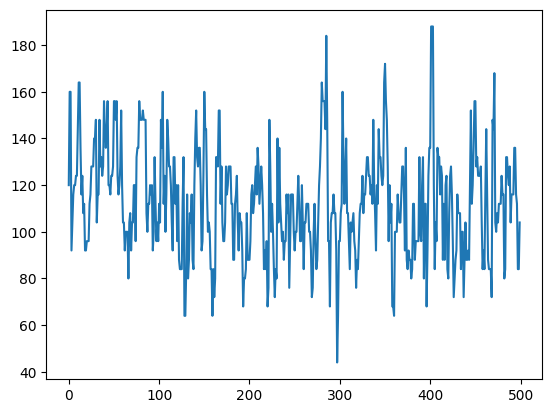

In [218]:
plt.plot(fitness_over_time_no_crossover)